<a href="https://colab.research.google.com/github/lookymlive/HORARIOS-PILATES/blob/main/tutorial_detecci%C3%B3n_de_objetos_con_YOLOv11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TUTORIAL: DETECCIÓN DE OBJETOS CON YOLO 11

En este tutorial veremos cómo usar un set de imágenes propio para afinar el modelo YOLO11 (la versión más reciente de Ultralytics) para realizar una tarea de detección de objetos.

Contenido:

1. ¿Qué es YOLO11?
2. Objetivo del tutorial
3. Preparación del dataset
4. Afinación de YOLO11 (detección) con el dataset
5. Generación de predicciones con el modelo afinado

## 1. ¿Qué es YOLO11?

YOLO11 es la última versión del modelo de detección de objetos de Ultralytics que permite realizar tareas como la detección de objetos, segmentación de instancias y la estimación de poses entre otras:

![](https://raw.githubusercontent.com/ultralytics/assets/main/im/banner-tasks.png)

Esta nueva versión ofrece cinco tamaños de modelo: Nano, Small, Medium, Large y X.

## 2. Objetivo del tutorial

En este tutorial veremos cómo afinar el modelo YOLO11 de detección de objetos usando un dataset propio.

## 3. Preparación del dataset

Según la documentación de Ultralytics, el set de imágenes debe estar estructurado de esta manera:

![](https://github.com/ultralytics/docs/releases/download/0/two-persons-tie-2.avif)

Además, los modelos disponibles son los siguientes:

![](https://drive.google.com/uc?export=view&id=1PYaeIKj57C4_nys6XPAJrZ2tfdwiYEZQ)


En todos los casos la dimensión más grande a usar en las imágenes es de 640 pixeles, así que tendremos que ajustar las imágenes de nuestro set de datos a este tamaño.

Además, usaremos el modelo más pequeño (YOLO11n) que contiene 2.6 millones de parámetros.

Estos son los pasos para tener disponible el set de datos desde Google Colab:

1. Primero debemos crear la carpeta "datasets" en el directorio "content" de Google Colab
2. Ahora descargamos el set de datos desde [este enlace](https://drive.google.com/file/d/15p5c3dGq3sm2bNUCevnHEOnwyC3MpE6L/view?usp=sharing).
3. Una vez descargado el archivo "dataset-vehiculos.zip" lo llevamos a la carpeta "datasets" de Google Colab
4. Ahora descomprimimos el archivo .zip:

In [ ]:
!unzip "/content/datasets/dataset_vehiculos.zip" -d /content/datasets

Archive:  /content/datasets/dataset_vehiculos.zip
   creating: /content/datasets/dataset_vehiculos/
  inflating: /content/datasets/dataset_vehiculos/.DS_Store  
   creating: /content/datasets/dataset_vehiculos/images/
  inflating: /content/datasets/dataset_vehiculos/images/.DS_Store  
   creating: /content/datasets/dataset_vehiculos/images/test/
  inflating: /content/datasets/dataset_vehiculos/images/test/frame_0498.jpg  
  inflating: /content/datasets/dataset_vehiculos/images/test/frame_0467.jpg  
  inflating: /content/datasets/dataset_vehiculos/images/test/frame_0473.jpg  
  inflating: /content/datasets/dataset_vehiculos/images/test/frame_0472.jpg  
  inflating: /content/datasets/dataset_vehiculos/images/test/frame_0466.jpg  
  inflating: /content/datasets/dataset_vehiculos/images/test/frame_0458.jpg  
  inflating: /content/datasets/dataset_vehiculos/images/test/frame_0470.jpg  
  inflating: /content/datasets/dataset_vehiculos/images/test/frame_0464.jpg  
  inflating: /content/datase

Y finalmente podemos eliminar el archivo .zip.

Verifiquemos que la estructura del set de datos es la especificada en la documentación de Ultralytics.

En total tendremos:

- 399 imágenes de entrenamiento
- 50 imágenes de validación
- 50 imágenes de prueba

Además, por cada imagen tendremos una etiqueta correspondiente. Esta etiqueta es un archivo que contiene el mismo nombre de la imagen y ubicado en la carpeta "labels".

Acá un ejemplo de uno de estos archivos:



```
0 0.217969 0.441667 0.091146 0.129630
0 0.332552 0.242593 0.043229 0.100000
0 0.291406 0.125463 0.031771 0.060185
0 0.238802 0.138426 0.031771 0.060185
0 0.297396 0.049074 0.023958 0.038889
0 0.320052 0.019907 0.017188 0.030556
0 0.465104 0.316204 0.055208 0.125000
0 0.495052 0.482407 0.067187 0.177778
0 0.141406 0.965278 0.116146 0.069444
```

En este caso:

- Cada fila corresponde a un objeto presente en la imagen. En total tendremos 9 filas y por tanto un total de 9 objetos
- Por cada objeto tendremos esta información: `class x_center y_center width height`.

Como en este caso queremos afinar el modelo para que detecte un solo tipo de objeto (0: vehículo) por tanto tendremos en todos los casos la categoría 0.

Observemos que las coordenadas del "bounding box" de cada objeto están normalizadas al tamaño de la imagen:

![](https://github.com/ultralytics/docs/releases/download/0/two-persons-tie.avif)

Ahora debemos crear el archivo .YAML que es como el índice del dataset y que debe seguir esta estructura:

```
path: ../datasets/coco8 # dataset root dir
train: images/train # train images (relative to 'path') 4 images
val: images/val # val images (relative to 'path') 4 images
test: # test images (optional)

# Classes (80 COCO classes)
names:
    0: person
    1: bicycle
    2: car
    # ...
    77: teddy bear
    78: hair drier
    79: toothbrush
```

Usemos el módulo "yaml" para crear este archivo:


In [ ]:
import yaml

data = {
    'path': '../datasets/dataset_vehiculos',
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'names': {
        0: 'car'
    }
}

with open('/content/datasets/dataset_vehiculos/data.yaml', 'w') as file:
    yaml.dump(data, file,
              default_flow_style=False,
              sort_keys=False)


Y listo. Ya tenemos listo el set de datos y ya podemos comenzar a hacer la afinación.

## 4. Afinación de YOLO11 (detección) con el dataset

Para poder acceder al modelo pre-entrenado debemos comenzar instalando la librería "ultralytics":

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 14.9 MB/s eta 0:00:00


Y tan sólo debemos llevar a cabo estos dos pasos para afinar el modelo:

1. Importar el modelo pre-entrenado
2. Usar el método "train" para realizar la afinación

Por defecto en cada iteración de entrenamiento se almacenarán los pesos del modelo afinado en la carpeta "runs". Se recomienda realizar la afinación usando la GPU (aunque con la CPU es posible, simplemente se requerirá más tiempo):

In [ ]:
from ultralytics import YOLO

# 1. Cargar el modelo (nano, el más pequeño)
model = YOLO("yolo11n.pt")

# Afinar el modelo
results = model.train(data="/content/datasets/dataset_vehiculos/data.yaml",
                      epochs=10, # Número de iteraciones
                      imgsz=640, # Tamaño de las imágenes (máxima dimensión)
                      plots=True, # Guardar gráficos de entrenamiento
                      )

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 55.1MB/s]


Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/datasets/dataset_vehiculos/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_co

100%|██████████| 755k/755k [00:00<00:00, 11.6MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/datasets/dataset_vehiculos/labels/train... 399 images, 0 backgrounds, 0 corrupt: 100%|██████████| 399/399 [00:00<00:00, 1827.02it/s]

train: New cache created: /content/datasets/dataset_vehiculos/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/datasets/dataset_vehiculos/labels/val... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<00:00, 952.60it/s]

val: New cache created: /content/datasets/dataset_vehiculos/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.46G      1.741      2.178      1.113        148        640: 100%|██████████| 25/25 [00:11<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.44s/it]

                   all         50        243     0.0149      0.922      0.258      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.39G      1.574      1.064      1.078        143        640: 100%|██████████| 25/25 [00:06<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.83it/s]

                   all         50        243     0.0161      0.996      0.206     0.0724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10       2.4G      1.532     0.9756      1.063        146        640: 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]

                   all         50        243          1      0.121      0.949      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.39G      1.494     0.9427      1.046        151        640: 100%|██████████| 25/25 [00:08<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         50        243       0.91      0.963       0.97      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.39G      1.501     0.9011      1.047        136        640: 100%|██████████| 25/25 [00:09<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         50        243      0.962      0.975      0.991      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10       2.4G       1.46     0.8443      1.031        140        640: 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         50        243      0.926      0.971      0.977      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10       2.4G      1.451     0.8228      1.027        136        640: 100%|██████████| 25/25 [00:07<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         50        243      0.996      0.992      0.995      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.39G      1.393     0.7918      1.013        139        640: 100%|██████████| 25/25 [00:08<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

                   all         50        243          1      0.988      0.995      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.39G      1.343     0.7519     0.9971        134        640: 100%|██████████| 25/25 [00:06<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         50        243      0.999      0.992      0.995      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10       2.4G      1.313     0.7309     0.9846        149        640: 100%|██████████| 25/25 [00:10<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         50        243      0.995      0.992      0.995      0.602



10 epochs completed in 0.032 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.4MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]


                   all         50        243      0.999      0.992      0.995      0.614
Speed: 0.3ms preprocess, 2.6ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train


Al realizar la afinación veremos impresas en pantalla varias métricas de las cuáles las más importantes son:

- "box_loss": mide el error en la ubicación y tamaño de los "bounding boxes" predichos en comparación con los de referencia. Se calcula como 1 - IntersectionOverUnion.
- "cls_loss": es el error en la clasificación del objeto dentro del "bounding box". Se calcula como la entropía cruzada
- "mAP": la precisión media que mide qué tan buenas detecciones genera el modelo (entre más cercano a 1 sea este valor mejor será el desempeño).

Después de unos minutos tendremos el modelo ya afinado. Este quedará almacenado en la carpeta `../runs/detect/train/weights/best.pt'`.

Podemos generar algunos gráficos del proceso de entrenamiento y validación para verificar que no haya "overfitting".

Por ejemplo grafiquemos las pérdidas para entrenamiento y validación:

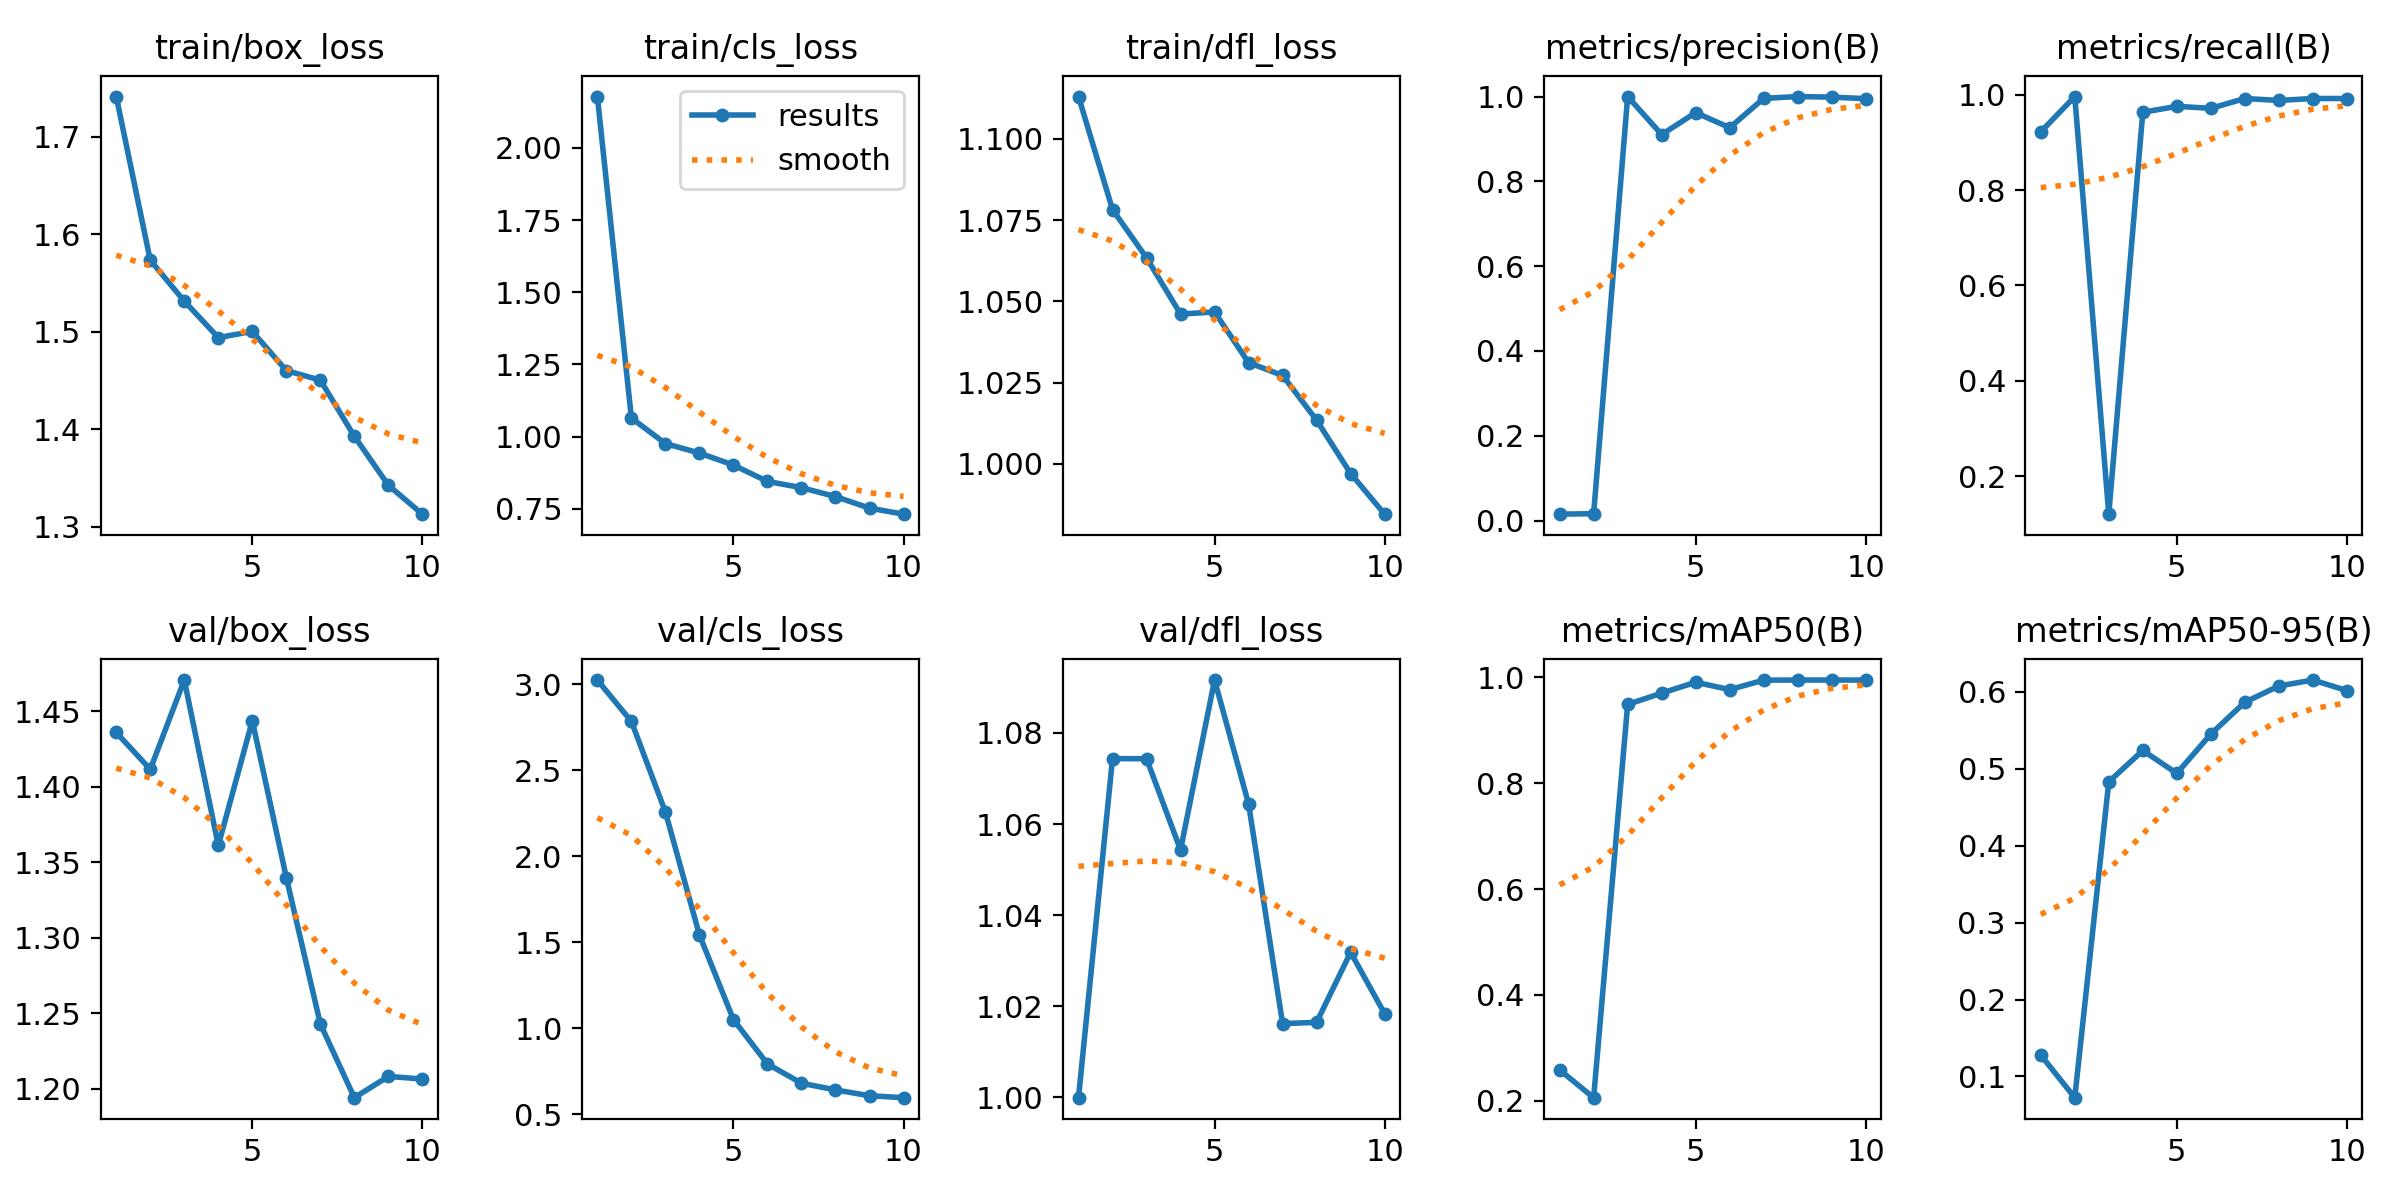

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename='/content/runs/detect/train/results.png', width=800)

Y al observar estas gráficas vemos que convergen a valores muy cercanos tanto en entrenamiento como en validación y por tanto podemos concluir que el modelo afinado generaliza bastante bien.

Podemos ver el desempeño de la clasificación de los objetos (dentro del proceso de detección) graficando la matriz de confusión:

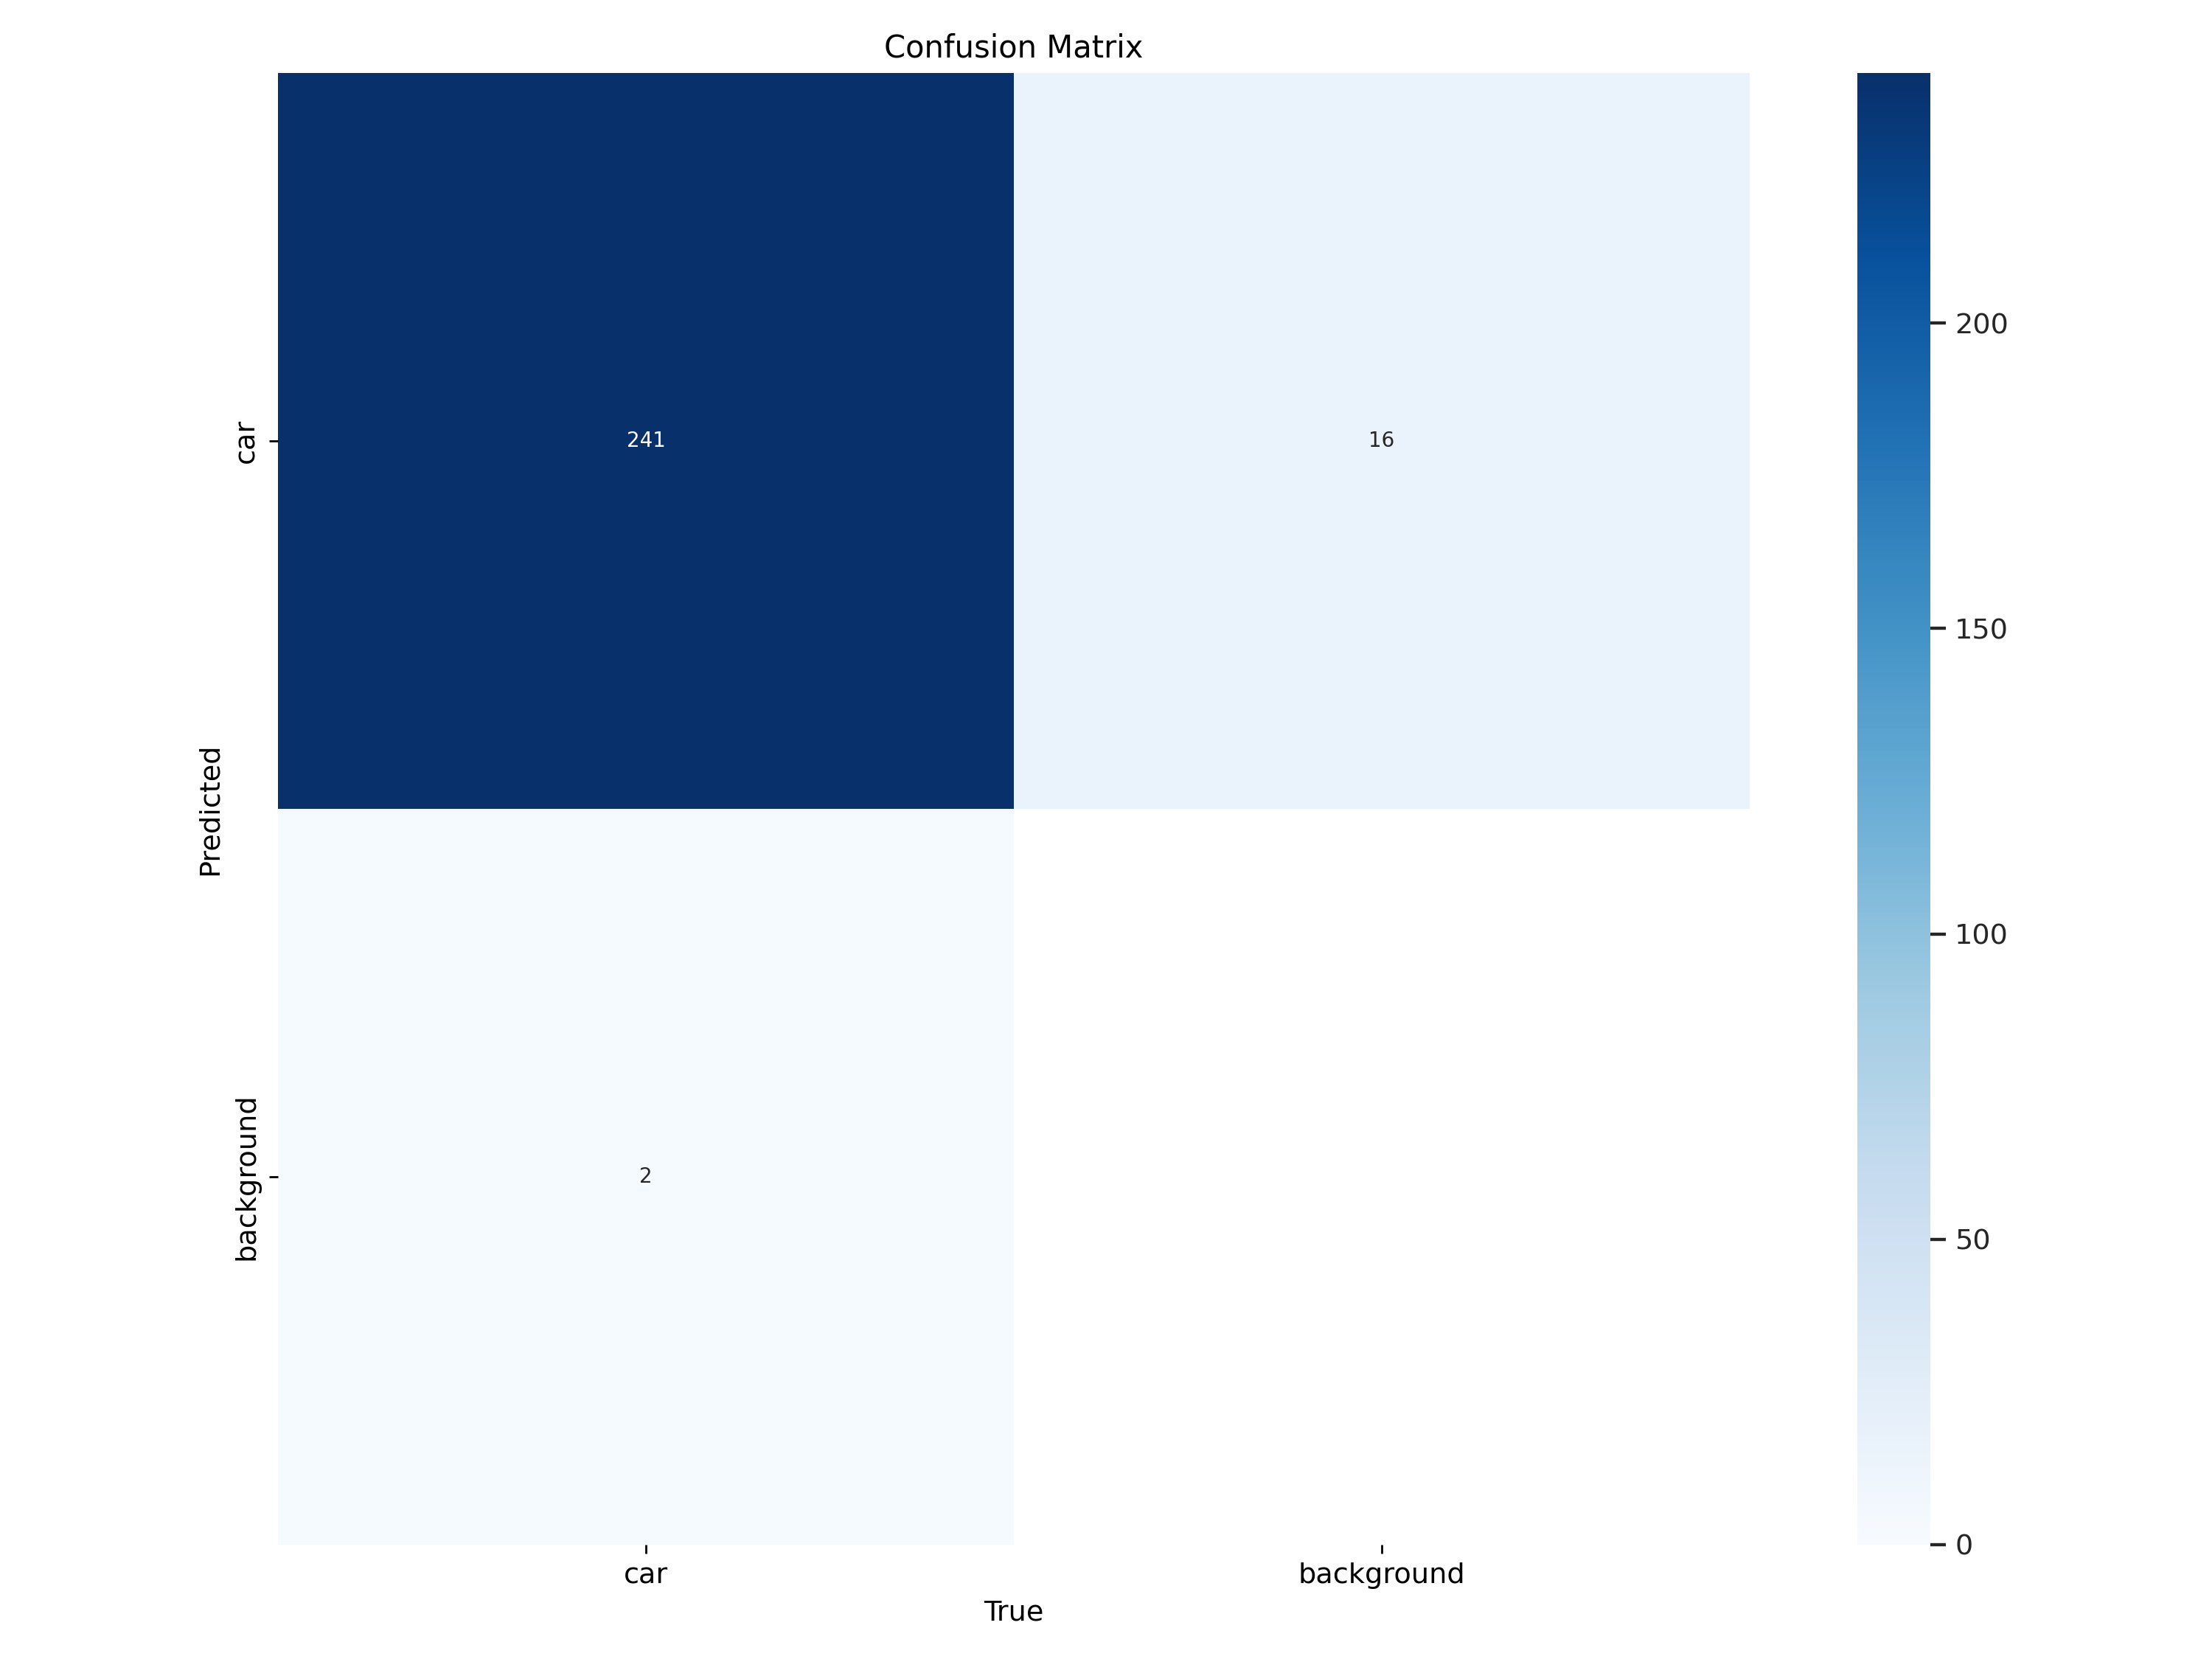

In [ ]:
IPyImage(filename='/content/runs/detect/train/confusion_matrix.png', width=600)

Y podemos ver que por ejemplo 1 vehículo ha sido detectado incorrectamente como fondo mientras que 20 porciones del fondo han sido detectadas incorrectamente como vehículos.

Incluso podemos ver el detalle de los datos usados para generar estas gráficas en el archivo results.csv.

## 5. Generación de predicciones con el modelo afinado

Y por último, podemos usar el set de prueba (disponible en la carpeta `../datasets/dataset_vehiculos/images/test`) para generar predicciones sobre nuevos datos usando el modelo afinado.

Comencemos cargando el modelo afinado:

In [ ]:
model = YOLO('/content/runs/detect/train/weights/best.pt')

Y ahora generemos predicciones sobre la totalidad del set de prueba (50 imágenes):

In [ ]:
preds = model('/content/datasets/dataset_vehiculos/images/test')


image 1/50 /content/datasets/dataset_vehiculos/images/test/frame_0449.jpg: 384x640 5 cars, 49.4ms
image 2/50 /content/datasets/dataset_vehiculos/images/test/frame_0450.jpg: 384x640 5 cars, 9.5ms
image 3/50 /content/datasets/dataset_vehiculos/images/test/frame_0451.jpg: 384x640 5 cars, 9.1ms
image 4/50 /content/datasets/dataset_vehiculos/images/test/frame_0452.jpg: 384x640 5 cars, 10.4ms
image 5/50 /content/datasets/dataset_vehiculos/images/test/frame_0453.jpg: 384x640 5 cars, 10.3ms
image 6/50 /content/datasets/dataset_vehiculos/images/test/frame_0454.jpg: 384x640 5 cars, 10.1ms
image 7/50 /content/datasets/dataset_vehiculos/images/test/frame_0455.jpg: 384x640 5 cars, 10.0ms
image 8/50 /content/datasets/dataset_vehiculos/images/test/frame_0456.jpg: 384x640 5 cars, 9.2ms
image 9/50 /content/datasets/dataset_vehiculos/images/test/frame_0457.jpg: 384x640 5 cars, 9.3ms
image 10/50 /content/datasets/dataset_vehiculos/images/test/frame_0458.jpg: 384x640 5 cars, 9.1ms
image 11/50 /content/da

Y para ver las predicciones generadas modemos simplemente acceder a una predicción individual y usar el método "show" para dibujar la imagen junto con el "bounding box" predicho:

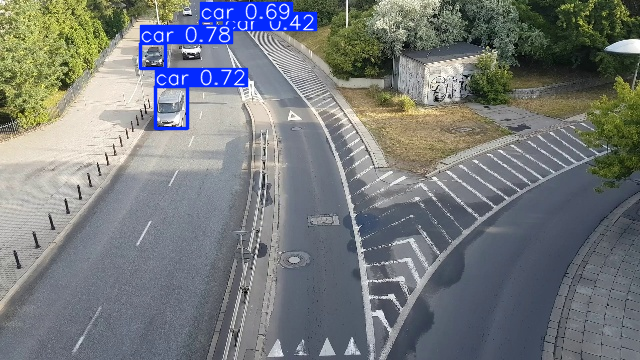

In [ ]:
# Mostrar predicciones
preds[49].show()